In [1]:
import numpy as np
import cv2
import math
import matplotlib.pyplot as plt
import matplotlib
import scipy.stats as stats
from skimage.exposure import match_histograms

matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)
path = './samples/'

## TODO
TERMINAR DEMO


Sacamos de la imagen dada los parámetros de transformación.
Para ello delimitamos el carril usado mediante 2 líneas laterales y 1 línea perpendicular, que marcará la frontera de la zona de trabajo.
Sacamos 4 puntos de interés, las 2 justamente donde está el capot del coche y otros 2 en la intersección de las líneas.

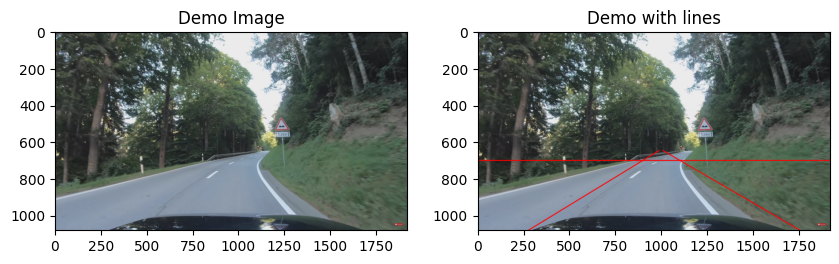

In [2]:
demo = cv2.imread(path + '02.png', -1)
demo = cv2.cvtColor(demo, cv2.COLOR_BGR2RGB)

plt.subplot(1,2,1)
demo_copy = np.copy(demo)
h,w,c = demo_copy.shape
plt.imshow(demo_copy)
plt.title('Demo Image')

pt1 = (275,h)
pt2 = (985, int (0.6*h))
cv2.line(demo,pt1,pt2,(255,0,0),3,cv2.LINE_AA)
pt3 = (1750,h)
pt4 = (1005, int (0.6*h))
cv2.line(demo,pt3,pt4,(255,0,0),3,cv2.LINE_AA)
pt5 = (0, int (0.65*h))
pt6 = (w, int (0.65*h))
cv2.line(demo,pt5,pt6,(255,0,0),3,cv2.LINE_AA)

plt.subplot(1,2,2)
plt.imshow(demo)
plt.title('Demo with lines')
plt.show()


In [3]:
def obtener_homografia():
    
    # Points of the rectangle in the road
    pts_src = np.array([[275, h],[1750, h],[896.25, int (0.65*h)],[1098.125, int (0.65*h)]])

    # Points of a rectangle without perspective with r=1.6
    pts_dst = np.array([[50, 905], [550, 905], [50, 100],[550, 100]])

    # Calculate Homography
    M, status = cv2.findHomography(pts_src, pts_dst)
    return M

Mapeamos los cuatro puntos obtenidos en un rectangulo y calculamos la matriz de transfomación.
Al aplicar la tranformación en la imágen inicial obtenemos otra, sin perspectiva alguna.

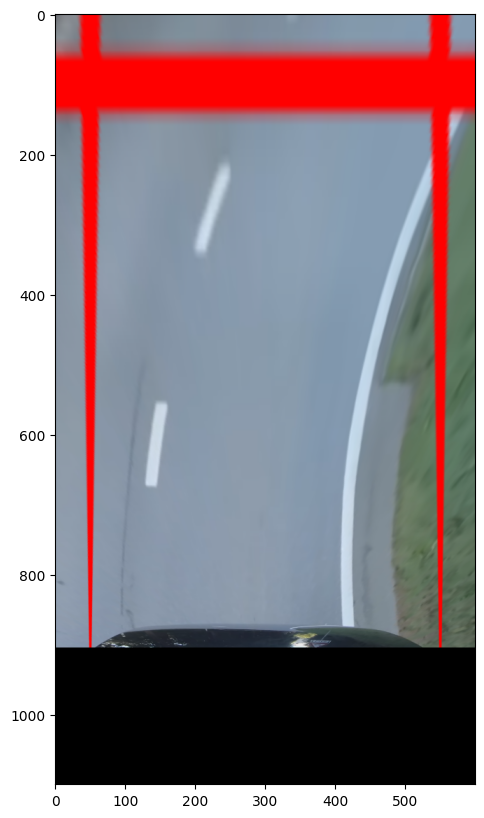

In [4]:
# Warp source image to destination based on homography
M = obtener_homografia()
no_perspective = cv2.warpPerspective(demo, M, (600,1100))

# Show image without perspective
plt.imshow(no_perspective)

Binarizamos la imagen resultante y obtenemos las líneas de carretera sin distorción.

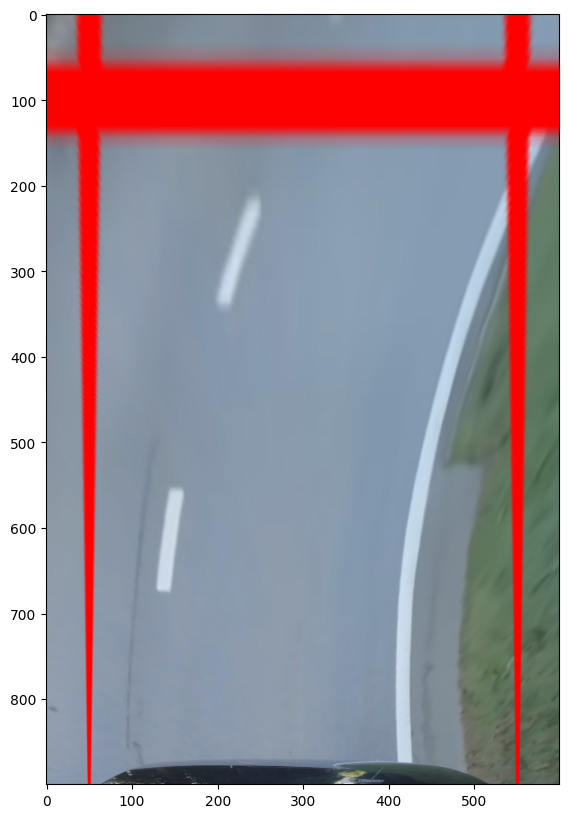

In [5]:

# Warp source image to destination based on homography
no_perspective = cv2.warpPerspective(demo, M, (600,900))
#no_perspective = cv2.warpPerspective(image, M, (500,500))

# Show image without perspective
plt.imshow(no_perspective)

# Save image
#im_out = cv2.cvtColor(no_perspective,cv2.COLOR_RGB2BGR)
#cv2.imwrite(images_path + "no_perspective.jpg",im_out);

In [7]:
#ret, binarized_no_perspective = cv2.threshold(no_perspective, 130, 255, cv2.THRESH_BINARY)

# Define horizontal and vertical kernels
#kernel_h = np.array([[1,0,-1],[2,0,-2],[1,0,-1]])*1/4
#kernel_v = np.array([[-1,-2,-1],[0,0,0],[1,2,1]])*1/4

# Apply convolution
#d_h = cv2.filter2D(binarized_no_perspective,cv2.CV_16S,kernel_h) # Using ddepth=cv2.CV_16S
#d_v = cv2.filter2D(binarized_no_perspective,cv2.CV_16S,kernel_v)

# And show them!
#gradient_image = np.add(np.absolute(d_h),np.absolute(d_v))

#Normalize gradient
#norm_gradient = np.copy(binarized_no_perspective)
#norm_gradient = cv2.normalize(gradient_image, norm_gradient, 0, 255, cv2.NORM_MINMAX)

# Threshold to get edges
#threshold = 20
#ret, edges = cv2.threshold(norm_gradient, threshold, 255,cv2.THRESH_BINARY)

#plt.imshow(edges, cmap = 'gray')

In [6]:
def reference_histogram (image, verbose=True):

    ref = cv2.imread(path+'ref2.png',0)
    if (verbose):
        plt.subplot(2,2,1)
        #plt.hist(ref.ravel(),256,[0,255])
        plt.imshow(image,cmap = 'gray')
        plt.title("Reference histogram")
    matched = match_histograms(image, ref)
    if (verbose):
        plt.subplot(2,2,2)
        plt.hist(matched.ravel(),256,[0,255])
        plt.title("New image histogram")
    return matched


In [7]:
def binarizar(imagen, verbose=True):
    lab = cv2.cvtColor(imagen,cv2.COLOR_RGB2Lab)
    matched_no_perspective = reference_histogram(lab [:,:,0], verbose)
    _,binarized_no_perspective = cv2.threshold(matched_no_perspective, 170, 255, cv2.THRESH_BINARY)
    
    if verbose:
        plt.subplot(2,2,3)
        plt.imshow(binarized_no_perspective,cmap ='gray')
        plt.title("No perspective binarization")
        
    return binarized_no_perspective

In [9]:
def calc_histograma(binarized_no_perspective, verbose = True):
    
    histogram = np.sum(binarized_no_perspective[int(binarized_no_perspective.shape[0]/2):,:], axis=0)  
    
    if verbose:
        plt.subplot(2,2,4).plot(histogram)
        plt.title("Histogram")
        plt.show()
        
    return histogram

In [10]:
def peaks(histogram, verbose=True):
    middle_point = int(histogram.shape[0]/2)
    if verbose:
        print(middle_point)
        
    left_peak = np.max(histogram[0:middle_point])
    left_index = np.where(histogram ==left_peak)[0][0]
    #left_index = histogram.index(left_peak)
    right_peak = np.max(histogram[middle_point:histogram.shape[0]])
    right_index = np.where(histogram[middle_point:histogram.shape[0]] == right_peak)[0][0] + middle_point
    return left_index,right_index

In [11]:
def sliding_window(img, p_base):
    ancho = 200 # window width
    alto = 11 # window height
    t = int(0.05*alto*ancho*2)
    img_h, img_w = img.shape
    
    puntos = np.zeros ( [(int(img_h/alto) - 1),2] ,dtype='int32') #(fila,columna)
    
    for i in range(3,int(img_h/alto) - int ((img_h/alto)*0.2)):
        aux = img[img_h - (alto * (i+1)):img_h - (alto * i), p_base - ancho : p_base + ancho]
        unos = np.where(aux == 255)
        puntos[i,:] = ([p_base,img_h - (alto * i)])
        
        if (np.size(unos) > t):
            p_base = (p_base - ancho) + int(np.mean(unos[1]))    
    puntos = puntos[puntos[:,0] != 0]
    return puntos

In [12]:
def lineas_laterales(histograma, binarized_no_perspective, verbose = True): 

    pico_i, pico_d = peaks(histograma)
    #print('pico i: ', pico_i, ', pico d: ', pico_d)
    puntos_i = sliding_window(binarized_no_perspective, pico_i)
    puntos_d = sliding_window(binarized_no_perspective, pico_d)
    #print (puntos_i[0:10,:])
    z_d = np.polyfit(puntos_d[:,1], puntos_d[:,0], 5) # ajuste polynomial
    puntos_d[:,0] = np.polyval(z_d,puntos_d[:,1]) # obteniendo nuevos puntos

    z_i = np.polyfit(puntos_i[:,1], puntos_i[:,0], 5) # ajuste polynomial
    puntos_i[:,0] = np.polyval(z_i,puntos_i[:,1]) # obteniendo nuevos puntos
    if verbose:
        plt.subplot(1,2,2)
        plt.imshow(binarized_no_perspective, cmap='gray')
        plt.title('image')
        plt.show()
        
    return puntos_i, z_i, puntos_d, z_d

In [13]:
def drawPoints (image, puntos):
    for i in range(np.size(puntos[:,0])):
        image = cv2.circle(image, (puntos[i,0],puntos[i,1]), 5, (200,200,200), -1)
    return image

In [14]:
def linea_central (pol_i,pol_d,puntos_i, verbose = False):
    pol_c = (pol_d+pol_i)/2
    if (verbose):
        print(pol_i, " ",pol_d)
        print("Pol central: ", pol_c)
    p_c = puntos_i
    p_c[:,0] = np.polyval(pol_c,puntos_i[:,1])
    aux = drawPoints(np.copy(binarized_no_perspective), p_c)
    if verbose:
        plt.imshow(aux)
    return p_c

In [15]:
def transformar_linea(puntos_c):
    a,b = puntos_c.shape
    linea_h = np.ones((b+1,a),dtype='int32')
    puntos_c=puntos_c.transpose()
    linea_h[0,:] = puntos_c[0,:]
    linea_h[1,:] = puntos_c[1,:]
    new_puntos = inv_M@linea_h
    new_puntos_c = new_puntos/new_puntos[2,:]
    puntos_t = np.ones((b,a),dtype='int32')
    puntos_t[0,:] = new_puntos_c[0,:]
    puntos_t[1,:] = new_puntos_c[1,:]
    puntos_t = puntos_t.transpose()
    return puntos_t

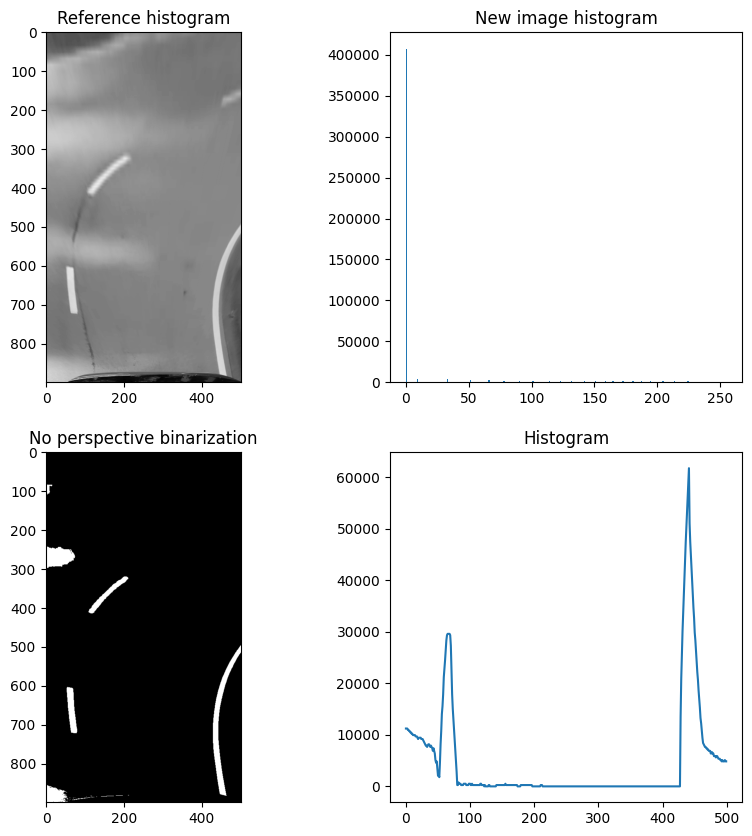

250


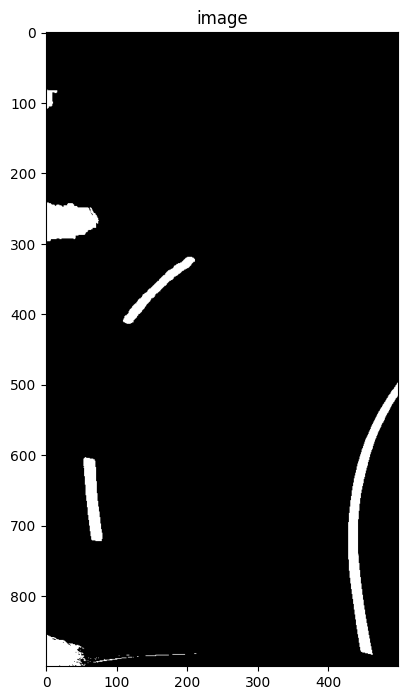

[[304. 867.]
 [303. 856.]
 [301. 845.]
 [300. 834.]
 [299. 823.]
 [297. 812.]
 [296. 801.]
 [295. 790.]
 [294. 779.]
 [293. 768.]
 [292. 757.]
 [291. 746.]
 [291. 735.]
 [291. 724.]
 [291. 713.]
 [292. 702.]
 [293. 691.]
 [294. 680.]
 [295. 669.]
 [296. 658.]
 [298. 647.]
 [300. 636.]
 [302. 625.]
 [304. 614.]
 [307. 603.]
 [309. 592.]
 [312. 581.]
 [314. 570.]
 [317. 559.]
 [320. 548.]
 [322. 537.]
 [325. 526.]
 [327. 515.]
 [329. 504.]
 [331. 493.]
 [333. 482.]
 [335. 471.]
 [337. 460.]
 [338. 449.]
 [339. 438.]
 [340. 427.]
 [341. 416.]
 [341. 405.]
 [341. 394.]
 [341. 383.]
 [341. 372.]
 [341. 361.]
 [340. 350.]
 [339. 339.]
 [338. 328.]
 [337. 317.]
 [336. 306.]
 [335. 295.]
 [334. 284.]
 [334. 273.]
 [334. 262.]
 [334. 251.]
 [334. 240.]
 [335. 229.]
 [337. 218.]
 [339. 207.]
 [343. 196.]]


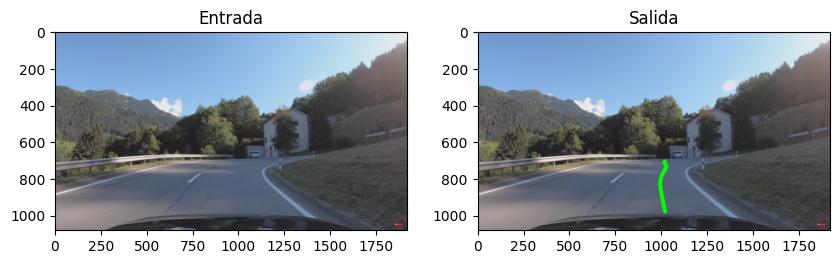

In [38]:
# MAIN
# abrimos la imagen
image_name = path + '06.png'
image = cv2.imread(image_name, -1)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

M = obtener_homografia()
inv_M = np.linalg.inv(M)

no_perspective = cv2.warpPerspective(np.copy(image), M, (500,900))
binarized_no_perspective = binarizar(no_perspective)
histograma = calc_histograma(binarized_no_perspective)
    
puntos_i, z_i, puntos_d, z_d = lineas_laterales(histograma, binarized_no_perspective)
#h,w,c = no_perspective.shape

h,w,_ = image.shape

puntos_c = linea_central(z_i,z_d, puntos_i)
#print (puntos_c)

puntos_acumulados = []

puntos_acumulados.append(puntos_c)
if(len(puntos_acumulados)>10):
    puntos_acumulados.pop(0)
print(np.mean(puntos_acumulados, axis = 0))



puntos_t = transformar_linea(puntos_c)

no_perspective = cv2.polylines(np.copy(image), np.int32([puntos_t]), isClosed=False, color=(0, 255, 0), thickness=20, lineType=cv2.LINE_AA)
plt.subplot(1,2,1)
plt.title('Entrada')
plt.imshow(image)

plt.subplot(1,2,2)
plt.title('Salida')
plt.imshow(no_perspective)

plt.show()

In [16]:
# MAIN

#abrimos video
captura = cv2.VideoCapture(path+'testVideo.avi')
puntos_acumulados = []
while (captura.isOpened()):
  ret, image = captura.read()
  if ret == True:
    #cv2.imshow('video', image)

    M = obtener_homografia()
    inv_M = np.linalg.inv(M)

    no_perspective = cv2.warpPerspective(np.copy(image), M, (600,900))
    binarized_no_perspective = binarizar(no_perspective,False)
    histograma = calc_histograma(binarized_no_perspective, False)

    try: 
      puntos_i, z_i, puntos_d, z_d = lineas_laterales(histograma, binarized_no_perspective, False)
      #h,w,c = no_perspective.shape

      h,w,_ = image.shape

      puntos_c = linea_central(z_i,z_d, puntos_i, False)

      puntos_acumulados.append(puntos_c)
      if(len(puntos_acumulados)>10):
        puntos_acumulados.pop(0)
      puntos_c =np.mean(puntos_acumulados, axis = 0)

      puntos_t = transformar_linea(puntos_c)

      no_perspective = cv2.polylines(np.copy(image), np.int32([puntos_t]), isClosed=False, color=(0, 255, 0), thickness=20, lineType=cv2.LINE_AA)

      cv2.imshow('no_perspective', no_perspective)

    except:
      print("No se detectaron líneas")
    
    if cv2.waitKey(30) == ord('s'):
      break
  else: 
    print("Video terminado")
    break
captura.release()
cv2.destroyAllWindows()



300
300
300
No se detectaron líneas
300
300
No se detectaron líneas
300
300
300
300
300
300
300
300
300
300
No se detectaron líneas
300
No se detectaron líneas
300
300
No se detectaron líneas
300
300
300
300
300
300
300
300
300
No se detectaron líneas
300
No se detectaron líneas
300
300
No se detectaron líneas
300
No se detectaron líneas
300
No se detectaron líneas
300
No se detectaron líneas
300
300
300
300
No se detectaron líneas
300
300
300
300
No se detectaron líneas
300
No se detectaron líneas
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
No se detectaron líneas
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
No se detectaron líneas
300
300
No se detectaron líneas
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300


In [125]:
## END SO FAR

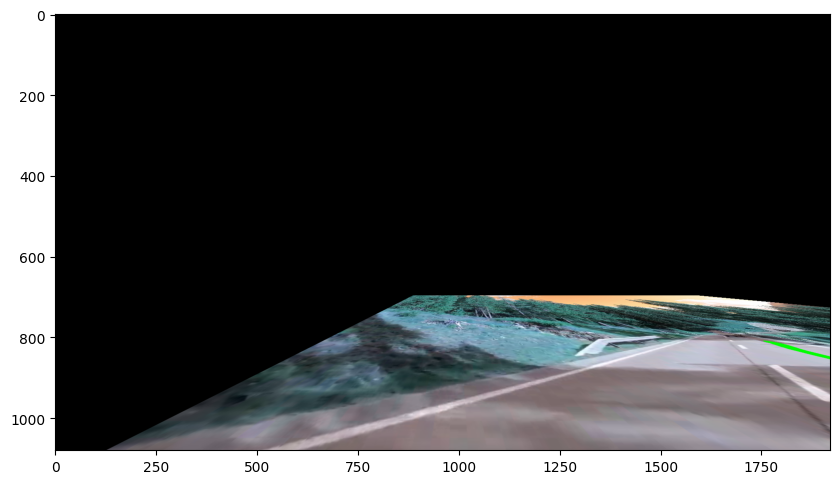

In [126]:
#FOR DEMO PURPOSES
inv_M = np.linalg.inv(M)
#puntos_en_original = cv2.warpPerspective(puntos_c, inv_M, (h,w))
#image = cv2.polylines(image, np.int32([puntos_en_original]), isClosed=False, color=(0, 255, 0), thickness=20, lineType=cv2.LINE_AA)

new_image = cv2.warpPerspective(no_perspective, inv_M, (w,h))
plt.imshow(new_image)

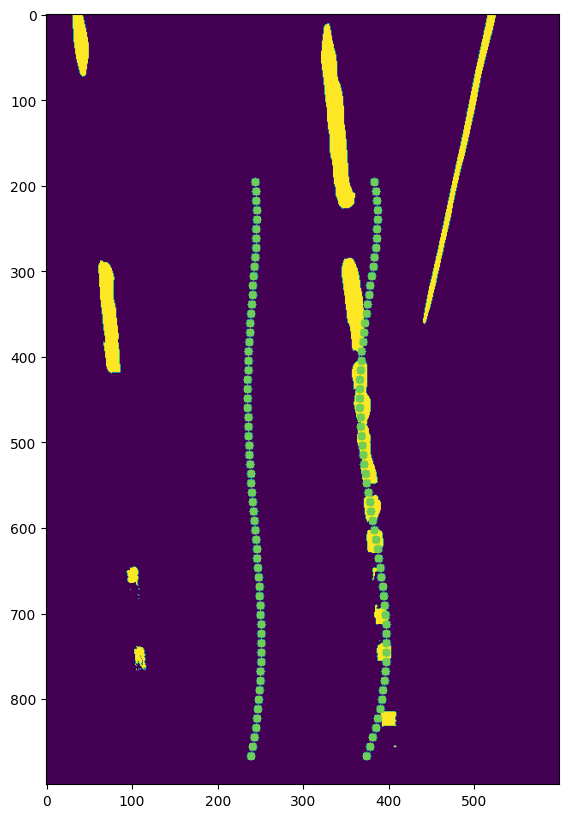

In [127]:
# FOR DEMO PURPOSES
withPoints = drawPoints(np.copy(binarized_no_perspective), puntos_i)
withPoints = drawPoints(withPoints, puntos_d)
plt.imshow(withPoints)

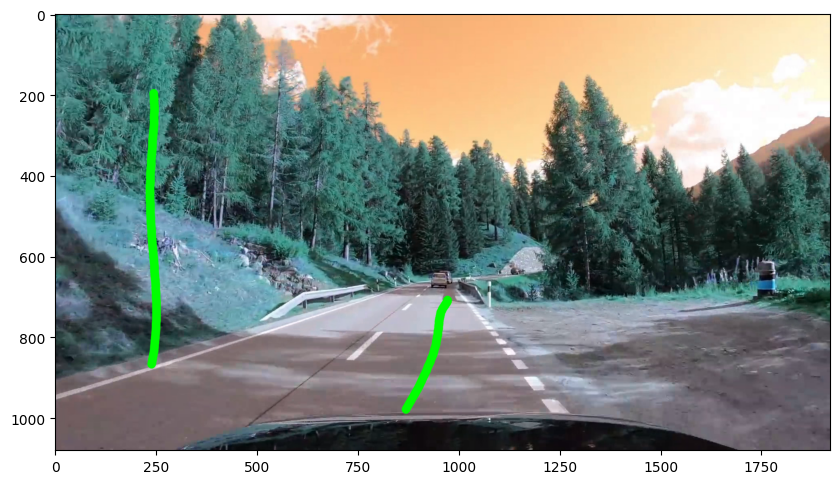

In [128]:
#FOR DEMO PURPOSES
no_perspective = cv2.polylines(no_perspective, np.int32([puntos_c]), isClosed=False, color=(0, 255, 0), thickness=20, lineType=cv2.LINE_AA)
#cv2.drawContours(im_aux, np.int32([puntos_c]), 0, (255,255,255), 2)
#plt.imshow(drawing)
plt.imshow(no_perspective)
#im_aux = binarized_no_perspective

In [129]:
from scipy import signal
def nonmaxsuppts(cim, radius, thresh):
    """ Binarize and apply non-maximum suppresion.   
    
        Args:
            cim: the harris 'R' image
            radius: the aperture size of local maxima window
            thresh: the threshold value for binarization
                    
        Returns: 
            r, c: two numpy vectors being the row (r) and the column (c) of each keypoint
    """   
    
    rows, cols = np.shape(cim)
    sze = 2 * radius + 1
    mx = signal.order_filter(cim, np.ones([sze, sze]), sze ** 2 - 1)
    bordermask = np.zeros([rows, cols]);
    bordermask[radius:(rows - radius), radius:(cols - radius)] = 1
    cim = np.array(cim)
    r, c = np.where((cim == mx) & (cim > thresh) & (bordermask == 1))
    return r, c

In [130]:
r,c = nonmaxsuppts(th, 15, thresh)
print(r.shape, ' ', c.shape)
for i in range( r.size):
    print(r[i], ' ', c[i])

NameError: name 'th' is not defined

In [ ]:
rho = 1
theta = np.pi/180
threshold = 175
lines = cv2.HoughLinesP(edges, rho, theta, threshold,
                        minLineLength=200,maxLineGap=15)
# For each line
for line in lines:
    # Draw the line in the RGB image
    x1,y1,x2,y2 = line[0]
    cv2.line(image,(x1,y1),(x2,y2),(255,0,0),2)

In [ ]:
thresh = 0.3*harris.max()
_,th = cv2.threshold(harris, thresh, 255, cv2.THRESH_BINARY)
plt.imshow(th,cmap='gray')